In [1]:
# Check for GPU
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.5.1+cu124
True
NVIDIA GeForce RTX 3080


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
from csv import DictReader
import csv
from datetime import datetime
import math

In [3]:
# Chunking
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Ollama
from langchain_ollama import OllamaEmbeddings
from langchain_ollama import ChatOllama
from langchain_chroma import Chroma

# Prompts
from langchain.prompts import PromptTemplate

# Runnables
from langchain.schema.runnable import RunnableSequence

In [4]:
# Do imports for squad_scoring and prompts
from pathlib import Path

utils_folder = Path("..")
sys.path.append(str(utils_folder))

utils_folder = Path("../src/deh")
sys.path.append(str(utils_folder))

import squad_scoring
import prompts

##### Set Global variables

In [20]:
# Folders for storing data and the results
DATA_ROOT = "../../../deh_data_results/data"         # Set to your own data folder
RESULTS_ROOT = "../../../deh_data_results/results"   # Set to your own results folder

# Vector Store Parameters
ollama_embedding_model = "avr/sfr-embedding-mistral"
embeddings = OllamaEmbeddings(model=ollama_embedding_model)
persist_directory = f"{DATA_ROOT}/chroma_deh_rag_db"
collection_name = "deh_rag"
VECTORIZE_SQUAD_DATASET = False      # Set to True to vectorize the squad dataset. If False, 
                                    # then the documents and their embeddings should already
                                    # exist in the vector store.
CREATE_QUESTION_CONTEXTS = True     # Set to True to create question contexts from the vector store; 
                                    # if False, the question contexts are loaded from a csv file.
CREATE_HYDE_CONTEXTS = False         # Set to True to create hyde contexts; if False,
                                    # the hyde contexts are loaded from a csv file.                                    

# LLM Parameters
CHAT_MODEL_NAME = "llama3.1"
MAX_TOKENS = 100
TEMPERATURE = 0.5
TOP_P = 0.95
FREQUENCY_PENALTY = 0.0
PRESENCE_PENALTY = 0.0

CURRENT_QUERY_PROMPT_IDX = 0

# Bootstrap Parameters
SAMPLE_SIZE = 500
BOOTSTRAPS_N = 10000
#TODO check if this code is ok for setting the seed
# SEED = 42
# set_seed = random.seed(SEED)

# Experiment Parameters - define all the experiments to run
experiments = [{"name": "NO_RAG", "rag": False, "rag_model": None, "query_prompt_idx": 0, "conduct": False},
               {"name": "BASIC_RAG", "rag": True, "rag_model": "basic", "query_prompt_idx": 1, "conduct": False},
               {"name": "BASIC_RAG_DONT_LIE", "rag": True, "rag_model": "basic_dont_lie", "query_prompt_idx": 2, "conduct": False},
               {"name": "BASIC_RAG_HYDE", "rag": True, "rag_model": "basic_hyde", "query_prompt_idx": 2, "conduct": True},
               {"name": "BASIC_RAG_MILVUS", "rag": True, "rag_model": "basic_milvus", "conduct": False},
               {"name": "BASIC_RAG_SEMANTIC_CHUNKING", "rag": True, "rag_model": "basic_semantic_chunking", "conduct": False},
               {"name": "BASIC_RAG_SUPPRESS_ANSWERS", "rag": True, "rag_model": "basic_suppress_answers", "query_prompt_idx": 2, "conduct": False},
               {"name": "FULL_RAG", "rag": True, "rag_model": "full", "conduct": False}]

PERSIST_ANSWER_SAMPLES = False   # Set to True to persist the llm answers for each sample, for each experiment


##### Define the prompts and a function to get the LLM

In [6]:
query_prompts = [
    PromptTemplate(
        template=prompts.rag_text_prompts[2],
        input_variables = ["question"]
    ),
    # PromptTemplate(
    #     template=prompts.rag_text_prompts[1],
    #     input_variables = ["context", "question"]
    # ),

    PromptTemplate(
        template = """
    You are an assistant for question-answering tasks.
    Please only use the following pieces of retrieved context to answer the question.
    Use ten words maximum and keep the answer concise.

    Question: {question}
    Context: {context}

    Answer:
    """,
        input_variables = ["context", "question"]
    ),

    PromptTemplate(
        template=("""
                You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just return 'DONT KNOW'. 
                If you know the answer, keep it as short and concise as possible,
                i.e. to a maximum of a couple of words.

                Question: {question}
                Context: {context}

                Answer:
                """
        ),
        input_variables=["context", "question"]
    ),
    PromptTemplate(
        template = prompts.hyde_prompts[1],
        input_variables = ["question"]
    )
]

In [7]:
# Create the llm instance, based on the current query prompt
def get_llm(current_query_prompt):
    llm = ChatOllama(
        prompt_template = current_query_prompt,
        model = CHAT_MODEL_NAME,
        max_tokens = MAX_TOKENS,
        temperature = TEMPERATURE,
        top_p = TOP_P,
        frequency_penalty = FREQUENCY_PENALTY,
        presence_penalty = PRESENCE_PENALTY,
        gpu_use = True
    )

    return llm

##### Intialize the Vector Store (Chroma; Milvus to be added later)

In [8]:
# Intiialize the Chroma vector store
vector_store = Chroma(
    collection_name = collection_name,
    embedding_function = embeddings,
    persist_directory = persist_directory
)

##### Load the SQuAD Dataset

In [12]:
data_file = f"{DATA_ROOT}/dev-v2.0.json"
dataset = squad_scoring.load_dataset(data_file)

articles = []
contexts = []
qas = []

for article in dataset:
    title = article["title"]
    articles.append(title)
    for p in article['paragraphs']:
        context = p["context"]
        contexts.append(context)
        for qa in p['qas']:
            question = qa["question"]
            id = qa["id"]
            is_impossible = qa["is_impossible"]
            if is_impossible:
                for pa in qa["plausible_answers"]:
                    answer = pa["text"]
                    qas.append({"title": title, "context": context, "qid": id, "question": question, 
                                "is_impossible": is_impossible, "answer": answer})
            else:
                for a in qa["answers"]:
                    answer = a["text"]
                    qas.append({"title": title, "context": context, "qid": id, "question": question, 
                                "is_impossible": is_impossible, "answer": answer})
                    #qas.append({"title": title, "context": context, "id": id, "question": question, "answer": answer})
            #qas.append({"title": title, "context": context, "id": id, "question": question})

# Store dataset as a csv file
csv_file = f"{DATA_ROOT}/dev-v2.0.csv"
with open(csv_file, mode='w') as file:
    fieldnames = ['title', 'context', 'qid', 'question', 'is_impossible', 'answer']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for qa in qas:
        writer.writerow(qa)

# Remove duplicates from qas (there are duplicates in qas, because many possible answers are the same)
qas = list({frozenset(item.items()): item for item in qas}.values())

# Find unique questions - needed for further processing
unique_questions = list(set([qa["question"] for qa in qas]))

# TODO ----------> !!!!!!!!!!! REMOVE is_impossible = False check
#unique_questions = list(set([qa["question"] for qa in qas if qa["is_impossible"] == False]))
#qas = [{"qid": squad_scoring.get_qid_from_question(question, dataset), "question": question} for question in unique_questions]


print(f"#articles in the dataset:            {len(articles)}")
print(f"#contexts in the dataset:          {len(contexts)}")
print(f"#questions in the dataset:        {len(qas)}")   
print(f"#unique entries in the dataset:   {len(unique_questions)}")

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! TO CHANGE #TODO
# Setting this variable just to make sure that the rest of the code works
# with the new variable name. This is because "qas" is used all over the place...
# qas = qas_bootstrapped_dataset

# Take sub-sample to shorten the time for the bootstrapping
#qas = random.sample(qas, SAMPLE_SIZE)


#TODO check if this code is ok for setting the seed
#set_seed = random.seed(SEED)


#articles in the dataset:            35
#contexts in the dataset:          1204
#questions in the dataset:        16209
#unique entries in the dataset:   11849


In [13]:
#unique_qas = list({frozenset(item.items()): item for item in qas}.values())

print(len(qas))
print(qas[0])


16209
{'title': 'Normans', 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.', 'qid': '56ddde6b9a695914005b9628', 'question': 'In what country is Normandy located?', 'is_impossible': False, 'answer': 'France'}


##### If configured, chunk the SQuAD dataset and add to the vector store

In [14]:
# if VECTORIZE_SQUAD_DATASET:
#     print(f"Creating contexts for the dataset...")

#     text_splitter = RecursiveCharacterTextSplitter(
#         chunk_size=400,
#         chunk_overlap=50
#     )
#     all_chunks = []
#     for context in contexts:
#         chunks = text_splitter.create_documents([context])
#         for chunk in chunks:
#             all_chunks.append(chunk)
        
#     print(f"Number of chunks --> {len(all_chunks)}\n")
#     print(chunks[0])      

#     for chunk in chunks:
#         chunk.metadata = {"source": "squad"}
    
#     ids = [str(i) for i in list(range(len(all_chunks)))]
#     vector_store.add_documents(documents=all_chunks, ids=ids);
# else:
#     print("Not vectorizing the SQuAD dataset...")


if VECTORIZE_SQUAD_DATASET:
    print(f"Creating contexts for the dataset...")

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100
    )

    all_contexts = "\n\n".join(contexts)
    chunks = text_splitter.create_documents([all_contexts])   

    print(f"Number of chunks --> {len(chunks)}\n")
    print(chunks[0])      

    for chunk in chunks:
        chunk.metadata = {"source": "squad"}
    
    ids = [str(i) for i in list(range(len(chunks)))]
    vector_store.add_documents(documents=chunks, ids=ids);
else:
    print("Not vectorizing the SQuAD dataset...")


Not vectorizing the SQuAD dataset...


##### Contexts

Questions:

- if configured: generate question contexts and then persist
- else: read the question and hyde contexts from a .csv file

Hyde:

- if configured: generate Hyde contexts and then persist
- else: read the Hyde contexts from a .csv fil


In [15]:
def persist_question_contexts(csv_file_path):

    # Write the the qas dataset including the question contexts to a CSV file
    with open(csv_file_path, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["qid", "question", "title", "context", "is_impossible", "question_context", "answer"])
        writer.writeheader()   # Write the header row
        writer.writerows(qas)  # Write the data rows

    print(f"Data successfully written to {csv_file_path}")


In [16]:
def persist_hyde_contexts(csv_file_path, hyde_contexts):

    # Write the the Hyde contexts to a CSV file
    with open(csv_file_path, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["question", "hyde_context"])
        writer.writeheader()   # Write the header row
        writer.writerows(hyde_contexts)  # Write the data rows

    print(f"Data successfully written to {csv_file_path}")


##### Getting question contexts (either generate them, or read from a file)

In [19]:
len(qas)

16209

In [ ]:
csv_file_path = f"{DATA_ROOT}/qas_with_question_contexts.csv"

if CREATE_QUESTION_CONTEXTS:
    print(f"Creating question contexts for the dataset and persisting these in a csv file...")
    for i, qa in enumerate(qas):
        if i %100 == 0:
            print(f"Processing question {i}...")
        question = qa["question"]
        
        top_docs = vector_store.similarity_search(
            query = question,
            k = 5
        )
        qa["question_context"] = " ".join([top_doc.page_content for top_doc in top_docs])
    
    persist_question_contexts(csv_file_path)

else:
    print(f"Reading qas and question contexts from a csv file...")
    
    # Read the qas (including contexts) from a CSV file
    qas = []

    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        
        for i, row in enumerate(csv_reader):
            if i == 0:
                continue
            qas.append({"qid": row[0], "question": row[1], "title": row[2],
                        "context": row[3], "is_impossible": row[4], 
                        "question_context": row[5], "answer": row[6]})


    # TODO --> !!!!!!!!!!!!!!!!!!!!!! 
    # qas = random.sample(qas, SAMPLE_SIZE)
    # print(f"len(qas) --> {len(qas)}")
    

Creating question contexts for the dataset and persisting these in a csv file...
Processing question 0...
Processing question 100...
Processing question 200...
Processing question 300...
Processing question 400...
Processing question 500...
Processing question 600...
Processing question 700...
Processing question 800...
Processing question 900...
Processing question 1000...
Processing question 1100...
Processing question 1200...
Processing question 1300...
Processing question 1400...
Processing question 1500...
Processing question 1600...
Processing question 1700...
Processing question 1800...
Processing question 1900...
Processing question 2000...
Processing question 2100...
Processing question 2200...
Processing question 2300...
Processing question 2400...
Processing question 2500...
Processing question 2600...
Processing question 2700...
Processing question 2800...
Processing question 2900...
Processing question 3000...
Processing question 3100...
Processing question 3200...
Process

In [23]:
print(len(qas))
qas[0]

16209


{'title': 'Normans',
 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
 'qid': '56ddde6b9a695914005b9628',
 'question': 'In what country is Normandy located?',
 'is_impossible': False,
 'answer': 'France',
 'question_context': 'Montgomery, Sinclair, Pollock, Burnard, Douglas and Gordon to na

In [21]:
def get_hyde_contexts_already_done(csv_file_path):
    if not os.path.exists(csv_file_path):
        return []

    hyde_contexts_already_done = []
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        
        for i, row in enumerate(csv_reader):
            if i == 0:
                continue
            hyde_contexts_already_done.append({"question": row[0], "hyde_context": row[1]})
    return hyde_contexts_already_done

In [22]:
csv_file_path = f"{DATA_ROOT}/hyde_contexts.csv"

hyde_contexts_already_done = get_hyde_contexts_already_done(csv_file_path)
hyde_questions_already_done = [hc["question"] for hc in hyde_contexts_already_done]
# print(hyde_questions_already_done)

if CREATE_HYDE_CONTEXTS:
    print(f"Creating Hyde contexts for the dataset and persisting these in a csv file...")
    unique_questions = list(set([qa["question"] for qa in qas]))
    print(f"Number of unique questions: {len(unique_questions)}")

    current_query_prompt = query_prompts[3]
    llm = get_llm(current_query_prompt)
    runnable_chain = RunnableSequence(current_query_prompt | llm)

    for i, question in enumerate(unique_questions[:300]):
        #if i %10 == 0:
        print("---------------------------------------------------------------")
        print(f"Processing question {i}...")
        print(f"Question: {question}")
        if question in hyde_questions_already_done:
            print("Question already done...")
            continue
        response = runnable_chain.invoke({"question": question})
        hyde_contexts_already_done.append({"question": question, "hyde_context": response.content})
        hyde_questions_already_done.append(question)
        print("")
    
    persist_hyde_contexts(csv_file_path, hyde_contexts_already_done)
    hyde_contexts = hyde_contexts_already_done

else:
    print(f"Reading the Hyde contexts from a csv file...")

    hyde_contexts = []
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        
        for i, row in enumerate(csv_reader):
            if i == 0:
                continue
            hyde_contexts.append({"question": row[0], "hyde_context": row[1]})


Reading the Hyde contexts from a csv file...


##### Define functions that are needed for experiments

In [27]:
# Create the runnable chain
def get_runnable_chain(current_query_prompt, llm):
    runnable_chain = RunnableSequence(current_query_prompt | llm)
    return runnable_chain

In [28]:
# Get the Hyde context for a question
# Could be made much more efficient by creating a dictionary of hyde contexts
def get_hyde_context(question):
    for hc in hyde_contexts:
        if hc["question"] == question:
            return hc["hyde_context"]
    return None

In [29]:
# generate the LLM answers, using a runnable chain and the sample of questions provided
def generate_llm_answers(runnable_chain, qas_sample, hyde=False):
    
    preds = {}

    sample_size = len(qas_sample)
    print(f"sample_size: {sample_size}")

    for i, qa in enumerate(qas_sample):

        question = qa["question"]
        if hyde:
            #context = qa["hyde_context"]
            context = get_hyde_context(question)
        else:
            context = qa["vector_store_context"]
            
        # print(f"question --> {question}")
        # print(context)
        response = runnable_chain.invoke({"context": context, "question": question})
                
        qid = squad_scoring.get_qid_from_question(question, dataset)
        
        if response.content.upper() == "DONT KNOW":
            llm_answer = ""
        else:
            llm_answer = response.content

        preds[qid] = llm_answer
        qas_sample[i]["llm_answer"] = llm_answer

    return preds


In [30]:
#%%capture

# Get the metrics for a set of predictions (preds) that have been generated in a run
def get_squad_metrics(dataset, preds, verbose=False):
    squad_metrics = squad_scoring.calc_squad_metrics(dataset, preds);
    return squad_metrics["precision"], squad_metrics["recall"], squad_metrics["f1"]


In [31]:
# Calculate the mean and confidence interval for a list of scores
# TODO: Check if this is calculation is correct !!
def calculate_mean_confidence_interval(scores_l):

    # Calculate mean
    mean = np.mean(scores_l)

    # Calculate 95% confidence interval
    
    # confidence = 0.95
    # n = len(scores_l)
    # std_err = stats.sem(scores_l)  # Standard error of the mean
    # h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)  # Margin of error
    # ci = (mean - h, mean + h)

    sample_std_dev = np.std(scores_l, ddof=1)
    # n = len(scores_l)
    # standard_error = sample_std_dev / np.sqrt(n)
    margin_of_error = 1.96 * sample_std_dev
    ci = (mean - margin_of_error, mean + margin_of_error)

    return mean, ci

In [32]:
# Generate a histogram for a list of scores and persist it
def generate_histogram(scores_l, mean, ci, results_folder_name, experiment_name):

    plt.clf
    plt.hist(scores_l, bins=30, density=False, edgecolor='black', alpha=0.6, color = 'lightblue' ) # color='aquamarine')
    plt.xlim(0, 100)
    plt.title(f"F1-Scores for {experiment_name} - (Bootstraps: {BOOTSTRAPS_N} - Sample Size: {SAMPLE_SIZE})", fontsize=10)
    plt.xlabel("F1-Score")
    plt.ylabel("Frequency")

    # Add a vertical line for the mean
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=2, label=f'Mean F1: {round(mean, 2)}')

    # Add vertical lines for the 95% confidence interval
    plt.axvline(ci[0], color='orange', linestyle='dashdot', linewidth=1.5, label='95% CI Lower')
    plt.axvline(ci[1], color='orange', linestyle='dashdot', linewidth=1.5, label='95% CI Upper')

    plt.legend(loc='upper right', fontsize=10)
    plt.savefig(os.path.join(results_folder_name, f"{experiment_name}_{BOOTSTRAPS_N}_{SAMPLE_SIZE}"))

##### Define functions for Bootstrapping

In [33]:
# Get the current timestamp and format the start timestamp as a string
def get_timestamp_as_string():
    start_timestamp = datetime.now()
    start_timestamp_str = start_timestamp.strftime('%Y%m%d_%H%M%S')
    return start_timestamp_str

In [51]:
# Adding f1, precision, recall for NO_RAG

def calculate_scores(qas, query_prompt_idx, experiment_name, context_needed=False, suppress_answers=False):

    # Create the chain
    current_query_prompt = query_prompts[query_prompt_idx]
    print(f"current_query_prompt = {current_query_prompt.template}\n")
    llm = get_llm(current_query_prompt)
    runnable_chain = get_runnable_chain(current_query_prompt, llm)

    # Generate the LLM answers for all questions and calculate per-answer metrics 
    preds = {}
    for i, qa in enumerate(qas):

        if i % 10 == 0:
            print(f"Processing question {i}...")

        qid = qa["qid"]
        question = qa["question"]

        if context_needed:
            context = qa["question_context"]
            response = runnable_chain.invoke({"question": question, "context": context})
        else:
            response = runnable_chain.invoke({"question": question})

        llm_answer = response.content

        if llm_answer.upper() == "DONT KNOW":
            if suppress_answers:
                continue
            else:
                llm_answer = ""

        preds[qid] = llm_answer
        scores = squad_scoring.calc_squad_metrics(dataset, preds)
        f1 = scores["f1"]
        precision = scores["precision"]
        recall = scores["recall"]

        preds = {}
        qa[f"{experiment_name.lower()}_llm_answer"] = llm_answer
        qa[f"{experiment_name.lower()}_f1"] = f1
        qa[f"{experiment_name.lower()}_precision"] = precision
        qa[f"{experiment_name.lower()}_recall"] = recall
        

In [35]:
def persist_results(results_folder_name, experiment_name, df):

    # if not os.path.exists(results_folder_name):
    #     os.makedirs(results_folder_name)
    # print(f"results_folder_name: {results_folder_name}")
    df = pd.DataFrame(qas)
    df.to_csv(f"{results_folder_name}/qas_{experiment_name.lower()}_scores.csv", header=True, index=False)

In [61]:
def do_bootstrapping(scores_l, results_folder_name, experiment_name, bootstraps_n = BOOTSTRAPS_N):

    mu_hats = []
    n = len(scores_l)
    print(f"scores_l: {scores_l}")
    for i in range(bootstraps_n):
        if i % 100 == 0:
            print(f"Processing sample {i}...")
        bootstrap_sample = random.choices(scores_l, k=n) # sample with replacement
        mu_hat = np.mean(bootstrap_sample)
        mu_hats.append(mu_hat)

    bootstraps_mean, ci = calculate_mean_confidence_interval(mu_hats)
    print(f"mu_hats: {mu_hats}")
    generate_histogram(mu_hats, bootstraps_mean, ci, results_folder_name, experiment_name)

In [37]:
def create_results_folder(experiment_name):
    start_timestamp_str = get_timestamp_as_string()
    results_folder_name = f"{RESULTS_ROOT}/{experiment_name}/results_{start_timestamp_str}"
    if not os.path.exists(results_folder_name):
        os.makedirs(results_folder_name, exist_ok=True)
    return results_folder_name

In [ ]:
def conduct_experiment(qas, experiment_name, query_prompt_idx, context_needed=False, suppress_answers=False):

    print(f"============= Creating results folder for {experiment_name} =============")
    results_folder_name = create_results_folder(experiment_name)
    
    print(f"============= Calculating scores for {experiment_name} =============")
    print(f"SAMPLE_SIZE: {SAMPLE_SIZE}")
    calculate_scores(qas, query_prompt_idx, experiment_name, context_needed, suppress_answers)


    print(f"============= Persisting results for {experiment_name} =============")
    df = pd.DataFrame(qas)
    persist_results(results_folder_name, experiment_name, df)

    print(f"============= Bootstrapping for {experiment_name} =============")
    print(f"BOOTSTRAPS_N: {BOOTSTRAPS_N}")
    do_bootstrapping(df[f"{experiment_name.lower()}_f1"].dropna().tolist(), results_folder_name, experiment_name, BOOTSTRAPS_N)

##### Creating a sample from qas for bootstrapping (will be used for all experiments)

In [86]:
# Getting qid, question, question_context
qas_for_bootstrapping = [{"qid": qa["qid"], "question": qa["question"], "question_context": qa["question_context"]} for qa in qas]
# Removing duplicates
qas_for_bootstrapping = list({frozenset(item.items()): item for item in qas_for_bootstrapping}.values())
# Taking a sample of size SAMPLE_SIZE
qas_for_bootstrapping = random.sample(qas_for_bootstrapping, SAMPLE_SIZE)

len(qas_for_bootstrapping)

500

##### Calculate Resulst for NO_RAG

============= Creating results folder for NO_RAG =============
============= Calculating scores for NO_RAG =============
SAMPLE_SIZE: 500
current_query_prompt = 
    You are an assistant for question-answering tasks.
    Use ten words maximum and keep the answer concise.

    Question: {question}

    Answer:
    

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
Processing question 100...
Processing question 110...
Processing question 120...
Processing question 130...
Processing question 140...
Processing question 150...
Processing question 160...
Processing question 170...
Processing question 180...
Processing question 190...
Processing question 200...
Processing question 210...
Processing question 220...
Processing question 230...
Processing question 240...
Processing question

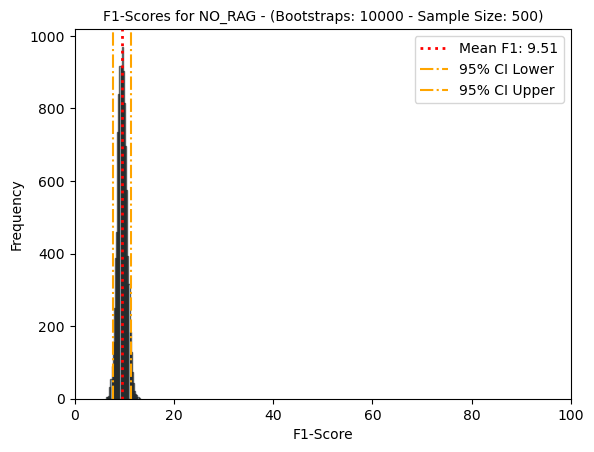

In [87]:
conduct_experiment(qas_for_bootstrapping, "NO_RAG", 0, False)


##### Calculating scores for BASIC_RAG

============= Creating results folder for BASIC_RAG =============
============= Calculating scores for BASIC_RAG =============
SAMPLE_SIZE: 500
current_query_prompt = 
    You are an assistant for question-answering tasks.
    Please only use the following pieces of retrieved context to answer the question.
    Use ten words maximum and keep the answer concise.

    Question: {question}
    Context: {context}

    Answer:
    

Processing question 0...
Processing question 10...
Processing question 20...
============= Persisting results for BASIC_RAG =============
============= Bootstrapping for BASIC_RAG =============
BOOTSTRAPS_N: 10000
scores_l: [0.0, 28.57142857142857, 0.0, 0.0, 100.0, 35.714285714285715, 0.0, 14.285714285714288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.0, 54.54545454545454, 30.76923076923077, 44.44444444444445, 66.66666666666666, 0.0, 30.0, 0.0, 0.0, 0.0, 100.0, 0.0, 40.0, 0.0]
Processing sample 0...
Processing sample 100...
Processing sample 200...
Processing sa

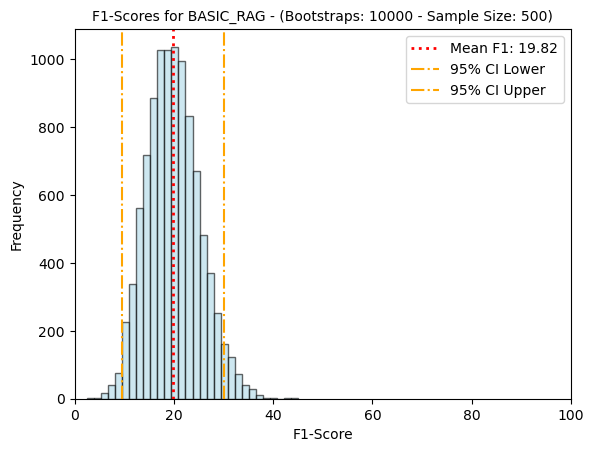

In [81]:
conduct_experiment(qas_for_bootstrapping, "BASIC_RAG", 1, True)


##### Calculate results for BASIC_RAG_DONT_LIE

============= Creating results folder for BASIC_RAG_DONT_LIE =============
============= Calculating scores for BASIC_RAG_DONT_LIE =============
SAMPLE_SIZE: 500
current_query_prompt = 
                You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just return 'DONT KNOW'. 
                If you know the answer, keep it as short and concise as possible,
                i.e. to a maximum of a couple of words.

                Question: {question}
                Context: {context}

                Answer:
                

Processing question 0...
Processing question 10...
Processing question 20...
============= Persisting results for BASIC_RAG_DONT_LIE =============
============= Bootstrapping for BASIC_RAG_DONT_LIE =============
BOOTSTRAPS_N: 10000
scores_l: [0.0, 100.0, 100.0, 0.0, 100.0, 50.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.

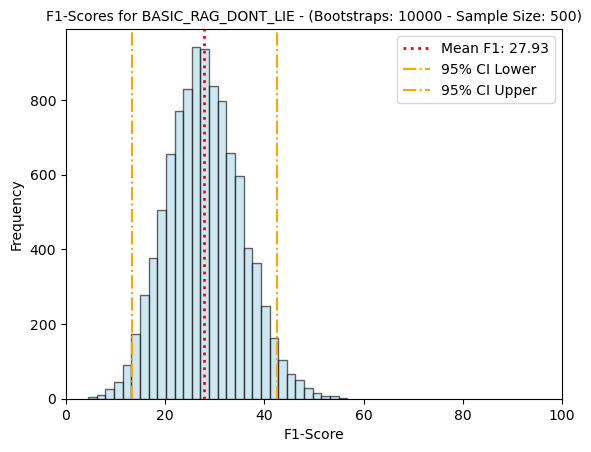

In [82]:
conduct_experiment(qas_for_bootstrapping, "BASIC_RAG_DONT_LIE", 2, True)

============= Creating results folder for BASIC_RAG_SUPPRESS_ANSWSERS =============
============= Calculating scores for BASIC_RAG_SUPPRESS_ANSWSERS =============
SAMPLE_SIZE: 500
current_query_prompt = 
                You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just return 'DONT KNOW'. 
                If you know the answer, keep it as short and concise as possible,
                i.e. to a maximum of a couple of words.

                Question: {question}
                Context: {context}

                Answer:
                

Processing question 0...
Processing question 10...
Processing question 20...
============= Persisting results for BASIC_RAG_SUPPRESS_ANSWSERS =============
============= Bootstrapping for BASIC_RAG_SUPPRESS_ANSWSERS =============
BOOTSTRAPS_N: 10000
scores_l: [0.0, 100.0, 100.0, 33.33333333333333, 0.0, 20.0, 0.0, 0.

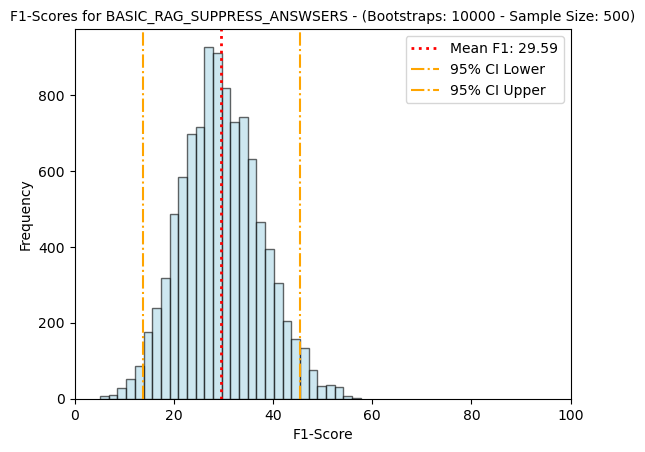

In [83]:
conduct_experiment(qas_for_bootstrapping, "BASIC_RAG_SUPPRESS_ANSWSERS", 2, context_needed=True, suppress_answers=True)

In [68]:
qas[3000:3100]

[{'title': 'Oxygen',
  'context': 'Highly concentrated sources of oxygen promote rapid combustion. Fire and explosion hazards exist when concentrated oxidants and fuels are brought into close proximity; an ignition event, such as heat or a spark, is needed to trigger combustion. Oxygen is the oxidant, not the fuel, but nevertheless the source of most of the chemical energy released in combustion. Combustion hazards also apply to compounds of oxygen with a high oxidative potential, such as peroxides, chlorates, nitrates, perchlorates, and dichromates because they can donate oxygen to a fire.',
  'qid': '571cebc05efbb31900334e4a',
  'question': 'Rather than the fuel, what is oxygen to a fire?',
  'is_impossible': False,
  'answer': 'the oxidant',
  'question_context': "Highly concentrated sources of oxygen promote rapid combustion. Fire and explosion hazards exist when concentrated oxidants and fuels are brought into close proximity; an ignition event, such as heat or a spark, is needed 

In [ ]:
# Adding f1, precision, recall for BASIC_RAG

# Get the current timestamp and format the start timestamp as a string
# start_timestamp = datetime.now()
# start_timestamp_str = start_timestamp.strftime('%Y%m%d_%H%M%S')

# Create the chain
current_query_prompt = query_prompts[1]
print(f"current_query_prompt = {current_query_prompt.template}\n")
llm = get_llm(current_query_prompt)
runnable_chain = get_runnable_chain(current_query_prompt, llm)

# Generate the LLM answers for all questions and calculate per-answer metrics 
preds = {}
for i, qa in enumerate(qas):

    if i % 10 == 0:
        print(f"Processing question {i}...")

    qid = qa["qid"]
    question = qa["question"]
    context = qa["question_context"]

    response = runnable_chain.invoke({"question": question, "context": context})                
    llm_answer = response.content
    preds[qid] = llm_answer

    scores = squad_scoring.calc_squad_metrics(dataset, preds)
    f1 = scores["f1"]
    precision = scores["precision"]
    recall = scores["recall"]

    preds = {}
    qa["basic_rag_llm_answer"] = llm_answer
    qa["basic_rag_f1"] = f1
    qa["basic_rag_precision"] = precision
    qa["basic_rag_recall"] = recall
    

current_query_prompt = 
    You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question.
    Use ten words maximum and keep the answer concise.

    Question: {question}
    Context: {context}

    Answer:
    

Processing question 0...
Processing question 10...
Processing question 20...
Processing question 30...
Processing question 40...
Processing question 50...
Processing question 60...
Processing question 70...
Processing question 80...
Processing question 90...
Processing question 100...
Processing question 110...
Processing question 120...
Processing question 130...
Processing question 140...
Processing question 150...
Processing question 160...
Processing question 170...
Processing question 180...
Processing question 190...
Processing question 200...
Processing question 210...
Processing question 220...
Processing question 230...
Processing question 240...
Processing question 250...
Processing question 260...
Proces

In [172]:
results_folder_name = f"{RESULTS_ROOT}/basic_rag/results_{start_timestamp_str}\n"
os.makedirs(results_folder_name)
print(f"results_folder_name: {results_folder_name}")
df = pd.DataFrame(qas)
df.to_csv(f"{results_folder_name}/qas_bootstrapped_dataset.csv", header=True, index=False)

results_folder_name: ../../../deh_data_results/results/basic_rag/results_20241127_132452



Processing sample 0...
Processing sample 100...
Processing sample 200...
Processing sample 300...
Processing sample 400...
Processing sample 500...
Processing sample 600...
Processing sample 700...
Processing sample 800...
Processing sample 900...
Processing sample 1000...
Processing sample 1100...
Processing sample 1200...
Processing sample 1300...
Processing sample 1400...
Processing sample 1500...
Processing sample 1600...
Processing sample 1700...
Processing sample 1800...
Processing sample 1900...
Processing sample 2000...
Processing sample 2100...
Processing sample 2200...
Processing sample 2300...
Processing sample 2400...
Processing sample 2500...
Processing sample 2600...
Processing sample 2700...
Processing sample 2800...
Processing sample 2900...
Processing sample 3000...
Processing sample 3100...
Processing sample 3200...
Processing sample 3300...
Processing sample 3400...
Processing sample 3500...
Processing sample 3600...
Processing sample 3700...
Processing sample 3800..

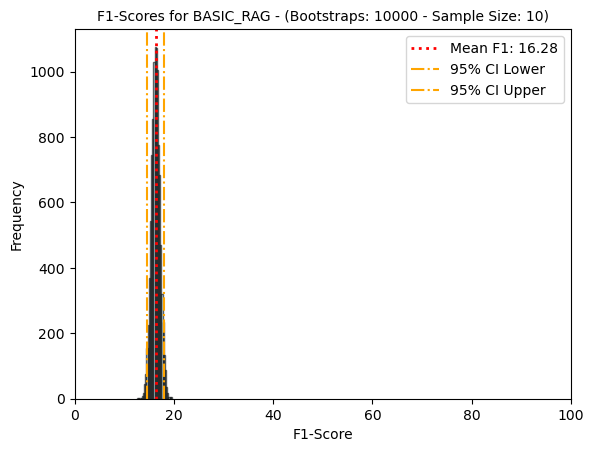

In [ ]:
# BOOTSTRAP_CNT = 10000
f1_means = do_bootstrapping(df["basic_rag_f1"].tolist(), samples_n=BOOTSTRAP_CNT)
bootstrap_mean, ci = calculate_mean_confidence_interval(f1_means)
generate_histogram(f1_means, bootstrap_mean, ci, results_folder_name, "BASIC_RAG")


##### Calculating the scores for BASIC_RAG_DONT_LIE

In [249]:
# Adding f1, precision, recall for BASIC_RAG_DONT_LIE

# Create the chain
current_query_prompt = query_prompts[2]
print(f"current_query_prompt = {current_query_prompt.template}\n")
llm = get_llm(current_query_prompt)
runnable_chain = get_runnable_chain(current_query_prompt, llm)

# Generate the LLM answers for all questions and calculate per-answer metrics 
preds = {}
dont_knows = []
for i, qa in enumerate(qas):

    if i % 10 == 0:
        print(f"Processing question {i}...")

    qid = qa["qid"]
    question = qa["question"]
    context = qa["question_context"]

    response = runnable_chain.invoke({"question": question, "context": context})                
    #llm_answer = response.content
    if response.content.upper() == "DONT KNOW":
        print("I don't know the answer...")
        dont_knows.append(question)
        llm_answer = ""
    else:
        llm_answer = response.content
    preds[qid] = llm_answer

    scores = squad_scoring.calc_squad_metrics(dataset, preds)
    f1 = scores["f1"]
    precision = scores["precision"]
    recall = scores["recall"]

    preds = {}
    qa["basic_rag_dontl_lie_llm_answer"] = llm_answer
    qa["basic_rag_dont_lie_f1"] = f1
    qa["basic_rag_dont_lie_precision"] = precision
    qa["basic_rag_dont_lie_recall"] = recall

current_query_prompt = 
                You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just return 'DONT KNOW'. 
                If you know the answer keep it as short and concise as possible,
                i.e. to a maximum of a couple of words.

                Question: {question}
                Context: {context}

                Answer:
                

Processing question 0...
I don't know the answer...
I don't know the answer...
Processing question 10...
I don't know the answer...
I don't know the answer...
I don't know the answer...
Processing question 20...
I don't know the answer...
I don't know the answer...
Processing question 30...
I don't know the answer...
I don't know the answer...
I don't know the answer...
Processing question 40...
Processing question 50...
I don't know the answer...
I don't know the answer...
I don't know the an

In [225]:
qas[:10]

[{'qid': '57285841ff5b5019007da19b',
  'question': 'How many research centers does the university run on campus?',
  'question_context': "Marine Biological Laboratory in Woods Hole, Mass. Although formally unrelated, the National Opinion Research Center is located on Chicago's campus. and was the first nominated by parents in 2009. In 2011, the Mines ParisTech : Professional Ranking World Universities ranked Harvard 1st university in the world in terms of number of alumni holding CEO position in Fortune Global 500 companies. Harvard for its reliance on teaching fellows for some aspects of undergraduate education; they consider this to adversely affect the quality of education. The Tech Coast is a moniker that has gained use as a descriptor for the region's diversified technology and industrial base as well as its multitude of prestigious and world-renowned research universities and other public and private institutions. Amongst these include 5 University of California campuses (Irvine,

In [250]:
results_folder_name = f"{RESULTS_ROOT}/basic_rag_dont_lie/results_{start_timestamp_str}\n"
#os.makedirs(results_folder_name)
print(f"results_folder_name: {results_folder_name}")
df = pd.DataFrame(qas)
df.to_csv(f"{results_folder_name}/qas_bootstrapped_dataset.csv", header=True, index=False)

results_folder_name: ../../../deh_data_results/results/basic_rag_dont_lie/results_20241127_132452



Processing sample 0...
Processing sample 100...
Processing sample 200...
Processing sample 300...
Processing sample 400...
Processing sample 500...
Processing sample 600...
Processing sample 700...
Processing sample 800...
Processing sample 900...
Processing sample 1000...
Processing sample 1100...
Processing sample 1200...
Processing sample 1300...
Processing sample 1400...
Processing sample 1500...
Processing sample 1600...
Processing sample 1700...
Processing sample 1800...
Processing sample 1900...
Processing sample 2000...
Processing sample 2100...
Processing sample 2200...
Processing sample 2300...
Processing sample 2400...
Processing sample 2500...
Processing sample 2600...
Processing sample 2700...
Processing sample 2800...
Processing sample 2900...
Processing sample 3000...
Processing sample 3100...
Processing sample 3200...
Processing sample 3300...
Processing sample 3400...
Processing sample 3500...
Processing sample 3600...
Processing sample 3700...
Processing sample 3800..

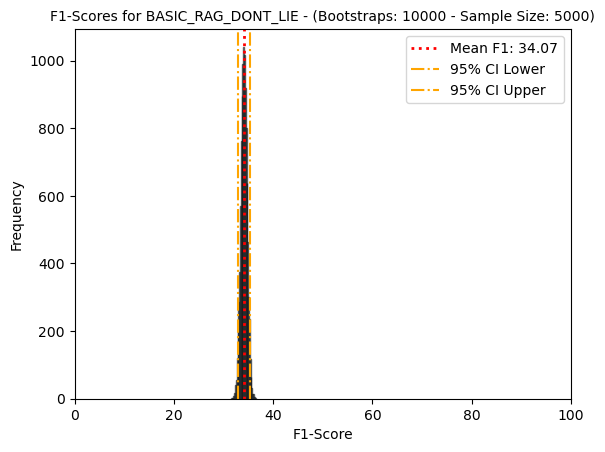

In [251]:
# BOOTSTRAP_CNT = 10000
f1_means = do_bootstrapping(df["basic_rag_dont_lie_f1"].tolist(), samples_n=BOOTSTRAP_CNT)
bootstrap_mean, ci = calculate_mean_confidence_interval(f1_means)
generate_histogram(f1_means, bootstrap_mean, ci, results_folder_name, "BASIC_RAG_DONT_LIE")


##### Calculating the scores for suppress answsers

In [23]:
len(qas)

1000

In [28]:
# Adding f1, precision, recall for BASIC_RAG_SUPPRESS_ANSWERS

# Create the chain
current_query_prompt = query_prompts[2]
print(f"current_query_prompt = {current_query_prompt.template}\n")
llm = get_llm(current_query_prompt)
runnable_chain = get_runnable_chain(current_query_prompt, llm)

# Generate the LLM answers for all questions and calculate per-answer metrics 
preds = {}
dont_knows = []
for i, qa in enumerate(qas):

    if i % 10 == 0:
        print(f"Processing question {i}...")

    qid = qa["qid"]
    question = qa["question"]
    context = qa["question_context"]

    response = runnable_chain.invoke({"question": question, "context": context})                
    #llm_answer = response.content
    if response.content.upper() == "DONT KNOW":
        print("I don't know the answer...")
        dont_knows.append(question)
        llm_answer = ""
    else:
        llm_answer = response.content

    qa["basic_rag_suppress_answers_llm_answer"] = llm_answer

    if llm_answer != "":
        preds[qid] = llm_answer
        scores = squad_scoring.calc_squad_metrics(dataset, preds)
        f1 = scores["f1"]
        precision = scores["precision"]
        recall = scores["recall"]

        qa["basic_rag_suppress_answers_f1"] = f1
        qa["basic_rag_suppress_answers_precision"] = precision
        qa["basic_rag_suppress_answers_recall"] = recall

    preds = {}

# Remove all answers that are empty (i.e. where the model did not know the answer)
qas = [qa for qa in qas if qa["basic_rag_suppress_answers_llm_answer"] != ""]

current_query_prompt = 
                You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just return 'DONT KNOW'. 
                If you know the answer keep it as short and concise as possible,
                i.e. to a maximum of a couple of words.

                Question: {question}
                Context: {context}

                Answer:
                

Processing question 0...
I don't know the answer...
Processing question 10...
I don't know the answer...
I don't know the answer...
Processing question 20...
I don't know the answer...
I don't know the answer...
I don't know the answer...
Processing question 30...
I don't know the answer...
I don't know the answer...
Processing question 40...
I don't know the answer...
I don't know the answer...
Processing question 50...
I don't know the answer...
I don't know the answer...
I don't know the an

In [29]:
qas[0]

{'qid': '5ad5036c5b96ef001a10a986',
 'question': 'What type of theatre is the Katyn Fotoplastikon?',
 'question_context': 'A fine tribute to the fall of Warsaw and history of Poland can be found in the Warsaw Uprising Museum and in the Katyń Museum which preserves the memory of the crime. The Warsaw Uprising Museum also operates a rare preserved and operating historic stereoscopic theatre, the Warsaw Fotoplastikon. The Museum of Independence preserves patriotic and political objects connected with Poland\'s struggles for independence. Dating back to 1936 Warsaw Historical Museum contains 60 rooms which host a permanent exhibition of the history of Warsaw from its origins until today. In the 1910s, New York–based filmmakers were attracted to Jacksonville\'s warm climate, exotic locations, excellent rail access, and cheap labor. Over the course of the decade, more than 30 silent film studios were established, earning Jacksonville the title of "Winter Film Capital of the World". However, 

In [32]:
results_folder_name = f"{RESULTS_ROOT}/basic_rag_suppress_answsers/results_{start_timestamp_str}\n"
os.makedirs(results_folder_name)
print(f"results_folder_name: {results_folder_name}")
df = pd.DataFrame(qas)
df.to_csv(f"{results_folder_name}/qas_bootstrapped_dataset.csv", header=True, index=False)

results_folder_name: ../../../deh_data_results/results/basic_rag_suppress_answsers/results_20241127_192400



Processing sample 0...
Processing sample 100...
Processing sample 200...
Processing sample 300...
Processing sample 400...
Processing sample 500...
Processing sample 600...
Processing sample 700...
Processing sample 800...
Processing sample 900...
Processing sample 1000...
Processing sample 1100...
Processing sample 1200...
Processing sample 1300...
Processing sample 1400...
Processing sample 1500...
Processing sample 1600...
Processing sample 1700...
Processing sample 1800...
Processing sample 1900...
Processing sample 2000...
Processing sample 2100...
Processing sample 2200...
Processing sample 2300...
Processing sample 2400...
Processing sample 2500...
Processing sample 2600...
Processing sample 2700...
Processing sample 2800...
Processing sample 2900...
Processing sample 3000...
Processing sample 3100...
Processing sample 3200...
Processing sample 3300...
Processing sample 3400...
Processing sample 3500...
Processing sample 3600...
Processing sample 3700...
Processing sample 3800..

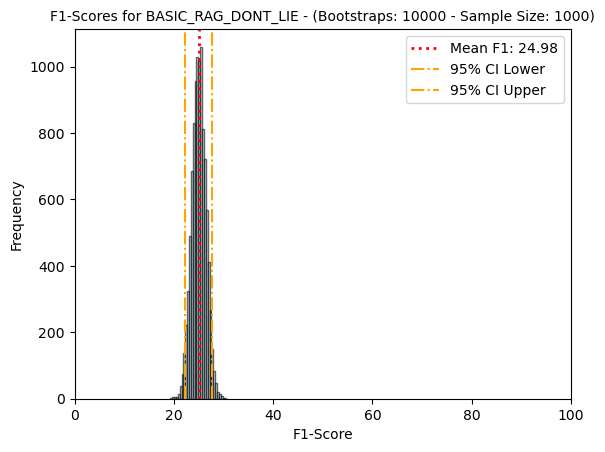

In [34]:
# BOOTSTRAP_CNT = 10000
f1_means = do_bootstrapping(df["basic_rag_suppress_answers_f1"].tolist(), samples_n=BOOTSTRAP_CNT)
bootstrap_mean, ci = calculate_mean_confidence_interval(f1_means)
generate_histogram(f1_means, bootstrap_mean, ci, results_folder_name, "BASIC_RAG_DONT_LIE")